# Data and Package Import

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import shap
import pickle

# import tensorflow

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Activation, Dropout

In [4]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [108]:
dataset = pd.read_csv('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/dataset.csv')

# Data Preperation

## Size up 'race' feature

In [109]:
dataset = dataset.drop(columns=['hadm_id'])

In [110]:
dataset['Length of ICU stay'] = dataset['Length of ICU stay']/ (24*60*60)

In [111]:
dataset['race'] = dataset['race'].str.replace(r'.*AFRICAN AMERICAN.*', 'African american', regex=True)
dataset['race'] = dataset['race'].str.replace(r'.*WHITE.*', 'White', regex=True)
dataset['race'] = dataset['race'].str.replace(r'.*HISPANIC.*', 'Hispanic', regex=True)
dataset.loc[~dataset['race'].isin(['White', 'African american', 'Hispanic']), 'race'] = 'Other'
dataset['gender'] = dataset['gender'].str.replace(r'.*M.*', 'Male', regex=True)
dataset['gender'] = dataset['gender'].str.replace(r'.*F.*', 'Female', regex=True)

In [112]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  int64  
 2   gender                                   30096 non-null  object 
 3   race                                     30096 non-null  object 
 4   mortality                                30096 non-null  int64  
 5   Minimum creatinine                       29865 non-null  float64
 6   Maximum creatinine                       29865 non-null  float64
 7   Maximum creatinine during day2 and day3  29792 non-null  float64
 8   Maximum heart rate                       30035 non-null  float64
 9   Mean heart rate                          30035 non-null  float64
 10  Minimum systolic bp                      26528

## Eliminatie outliers

In [113]:
# eliminate outliers
dataset_copy = dataset.copy()
predictors_continuous = dataset_copy.drop(columns=['gender', 'race', 'mortality'])

predictors_continuous['Maximum creatinine'] = predictors_continuous['Maximum creatinine'].where(predictors_continuous['Maximum creatinine'] <= 50, np.nan)
predictors_continuous['Minimum creatinine'] = predictors_continuous['Minimum creatinine'].where(predictors_continuous['Minimum creatinine'] <= 50, np.nan)
predictors_continuous['Maximum creatinine during day2 and day3'] = predictors_continuous['Maximum creatinine during day2 and day3'].where(predictors_continuous['Maximum creatinine during day2 and day3'] <= 1000, np.nan)

predictors_continuous['Maximum heart rate'] = predictors_continuous['Maximum heart rate'].where(predictors_continuous['Maximum heart rate'] <= 300, np.nan)
predictors_continuous['Mean heart rate'] = predictors_continuous['Mean heart rate'].where(predictors_continuous['Mean heart rate'] <= 300, np.nan)

predictors_continuous['Minimum spo2'] = predictors_continuous['Minimum spo2'].where(predictors_continuous['Minimum spo2'] <= 100, np.nan)
predictors_continuous['Mean spo2'] = predictors_continuous['Mean spo2'].where(predictors_continuous['Mean spo2'] <= 100, np.nan)

predictors_continuous['Minimum prothrombin'] = predictors_continuous['Minimum prothrombin'].where(predictors_continuous['Minimum prothrombin'] <= 1000, np.nan)
predictors_continuous['Maximum prothrombin'] = predictors_continuous['Maximum prothrombin'].where(predictors_continuous['Maximum prothrombin'] <= 1000, np.nan)

predictors_continuous['Mean systolic bp'] = predictors_continuous['Mean systolic bp'].where(predictors_continuous['Mean systolic bp'] <= 500, np.nan)

predictors_continuous['Mean diastolic bp'] = predictors_continuous['Mean diastolic bp'].where(predictors_continuous['Mean diastolic bp'] <= 2000, np.nan)

predictors_continuous['Maximum respiratory rate'] = predictors_continuous['Maximum respiratory rate'].where(predictors_continuous['Maximum respiratory rate'] <= 500, np.nan)

predictors_continuous['Mean respiratory rate'] = predictors_continuous['Mean respiratory rate'].where(predictors_continuous['Mean respiratory rate'] <= 500, np.nan)

predictors_continuous['Maximum sodium'] = predictors_continuous['Maximum sodium'].where(predictors_continuous['Maximum sodium'] <= 500, np.nan)

# predictors_continuous['Sodium Mean'].plot()
# predictors_continuous.info()

In [114]:
mean = predictors_continuous.mean(axis=0, skipna=True)
std = predictors_continuous.std(axis=0, skipna=True)
pd.DataFrame({'Mean': mean, 'Std': std})
# predictors_continuous.info()

,Mean,Std
stay_id,3.498016e+07,2.889898e+06
Age,6.620066e+01,1.504369e+01
Minimum creatinine,1.467875e+00,1.498831e+00
Maximum creatinine,1.693178e+00,1.758836e+00
Maximum creatinine during day2 and day3,1.694666e+00,1.693505e+00
Maximum heart rate,1.281930e+02,1.219978e+01
Mean heart rate,8.670237e+01,1.383710e+01
Minimum systolic bp,9.346460e+01,1.896775e+01
Mean systolic bp,1.170704e+02,1.844904e+01
Minimum diastolic bp,4.775952e+01,1.282603e+01


In [115]:
predictors_categorical = dataset_copy[['stay_id', 'gender', 'race']]
predictors_categorical['gender'].value_counts()
predictors_categorical['race'].value_counts() / predictors_categorical['race'].count()
# predictors_categorical.info()

White               0.675472
Other               0.196870
African american    0.093169
Hispanic            0.034490
Name: race, dtype: float64

## Complete the missing values

In [116]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [117]:
df_raw = predictors_continuous.copy()
missing_mask = df_raw.isna()
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(df_raw)
imputed_df = pd.DataFrame(imputed_values, index=df_raw.index, columns=df_raw.columns)

In [118]:
df_raw[missing_mask] = imputed_df[missing_mask]
predictors_continuous = df_raw.copy()

In [119]:
predictors_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  int64  
 2   Minimum creatinine                       30096 non-null  float64
 3   Maximum creatinine                       30096 non-null  float64
 4   Maximum creatinine during day2 and day3  30096 non-null  float64
 5   Maximum heart rate                       30096 non-null  float64
 6   Mean heart rate                          30096 non-null  float64
 7   Minimum systolic bp                      30096 non-null  float64
 8   Mean systolic bp                         30096 non-null  float64
 9   Minimum diastolic bp                     30096 non-null  float64
 10  Mean diastolic bp                        30096

## Normaliztion

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
temp = predictors_continuous.iloc[:, 1:]

columns = temp.columns
temp_normalized = scaler.fit_transform(temp)

temp1 = pd.DataFrame(temp_normalized, columns=columns)

predictors_continuous = pd.concat([predictors_continuous['stay_id'], temp1], axis=1)

In [121]:
predictors_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  float64
 2   Minimum creatinine                       30096 non-null  float64
 3   Maximum creatinine                       30096 non-null  float64
 4   Maximum creatinine during day2 and day3  30096 non-null  float64
 5   Maximum heart rate                       30096 non-null  float64
 6   Mean heart rate                          30096 non-null  float64
 7   Minimum systolic bp                      30096 non-null  float64
 8   Mean systolic bp                         30096 non-null  float64
 9   Minimum diastolic bp                     30096 non-null  float64
 10  Mean diastolic bp                        30096

## Get the data that will be used for fitting model

In [122]:
y = dataset_copy['mortality']
X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
X = X.drop(columns=['stay_id'])
variables_cont = X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(X['gender'], drop_first=True)
variable_race = pd.get_dummies(X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)

In [123]:
feature_names = X.columns

In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30096 entries, 0 to 30095
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Age                                      30096 non-null  float64
 1   Minimum creatinine                       30096 non-null  float64
 2   Maximum creatinine                       30096 non-null  float64
 3   Maximum creatinine during day2 and day3  30096 non-null  float64
 4   Maximum heart rate                       30096 non-null  float64
 5   Mean heart rate                          30096 non-null  float64
 6   Minimum systolic bp                      30096 non-null  float64
 7   Mean systolic bp                         30096 non-null  float64
 8   Minimum diastolic bp                     30096 non-null  float64
 9   Mean diastolic bp                        30096 non-null  float64
 10  Minimum spo2                             30096

In [125]:
X = X.to_numpy()
y = y.to_numpy()

In [126]:
X.shape

(30096, 38)

In [127]:
X = X.reshape(30096, 38,1)
y = y.reshape(30096,1)

In [128]:
X.shape

(30096, 38, 1)

# Train the model

In [129]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05, random_state=0)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


from keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from tensorflow.keras.metrics import TrueNegatives, FalsePositives, TrueNegatives, FalseNegatives

class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = TrueNegatives()
        self.false_positives = FalsePositives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Assuming y_pred are probabilities
        self.true_negatives.update_state(y_true, y_pred, sample_weight)
        self.false_positives.update_state(y_true, y_pred, sample_weight)

    def result(self):
        specificity = self.true_negatives.result() / (self.true_negatives.result() + self.false_positives.result())
        return specificity

    def reset_state(self):
        self.true_negatives.reset_states()
        self.false_positives.reset_states()

    def get_config(self):
        base_config = super(Specificity, self).get_config()
        return {**base_config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class NPV(tf.keras.metrics.Metric):
    def __init__(self, name='npv', **kwargs):
        super(NPV, self).__init__(name=name, **kwargs)
        self.true_negatives = TrueNegatives()
        self.false_negatives = FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Assuming y_pred are probabilities
        self.true_negatives.update_state(y_true, y_pred, sample_weight)
        self.false_negatives.update_state(y_true, y_pred, sample_weight)

    def result(self):
        npv = self.true_negatives.result() / (self.true_negatives.result() + self.false_negatives.result())
        return npv

    def reset_state(self):
        self.true_negatives.reset_states()
        self.false_negatives.reset_states()

    def get_config(self):
        base_config = super(NPV, self).get_config()
        return {**base_config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)



optimizer = Adam(learning_rate=0.0001)

# model selection by monitoring validation loss
checkpoint_path = "/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(38, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(filters=24, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['binary_accuracy', AUC(name='auc'), Precision(name='ppv'), Recall(name='sensitivity'), Specificity(), NPV()])

In [27]:
model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpoint])
# model.fit(X_train, Y_train, epochs=50, verbose=1, callbacks=[checkpoint_1])

Epoch 1/20
846/847 [============================>.] - ETA: 0s - loss: 0.6581 - binary_accuracy: 0.6108 - auc: 0.6493 - ppv: 0.5847 - sensitivity: 0.4786 - specificity: 0.7198 - npv: 0.6261
Epoch 1: val_loss improved from inf to 0.61497, saving model to /content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN
847/847 [==============================] - 17s 16ms/step - loss: 0.6581 - binary_accuracy: 0.6109 - auc: 0.6493 - ppv: 0.5847 - sensitivity: 0.4787 - specificity: 0.7198 - npv: 0.6262 - val_loss: 0.6150 - val_binary_accuracy: 0.6744 - val_auc: 0.7318 - val_ppv: 0.6634 - val_sensitivity: 0.5884 - val_specificity: 0.7472 - val_npv: 0.6820
Epoch 2/20
847/847 [==============================] - ETA: 0s - loss: 0.6233 - binary_accuracy: 0.6599 - auc: 0.7064 - ppv: 0.6351 - sensitivity: 0.5809 - specificity: 0.7249 - npv: 0.6773
Epoch 2: val_loss improved from 0.61497 to 0.60479, saving model to /content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN
847/847 [============

In [28]:
baseline_CNN = tf.keras.models.load_model(checkpoint_path, custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_CNN.evaluate(X_test, y_test, verbose=1)

48/48 [==============================] - 1s 4ms/step - loss: 0.5694 - binary_accuracy: 0.6983 - auc: 0.7744 - ppv: 0.6939 - sensitivity: 0.6136 - specificity: 0.7703 - npv: 0.7013


[0.5694162249565125,
 0.6983388662338257,
 0.7743513584136963,
 0.6939443349838257,
 0.6136034727096558,
 0.7702702879905701,
 0.7013422846794128]

In [ ]:
baseline_CNN.summary()

48/48 [==============================] - 0s 2ms/step


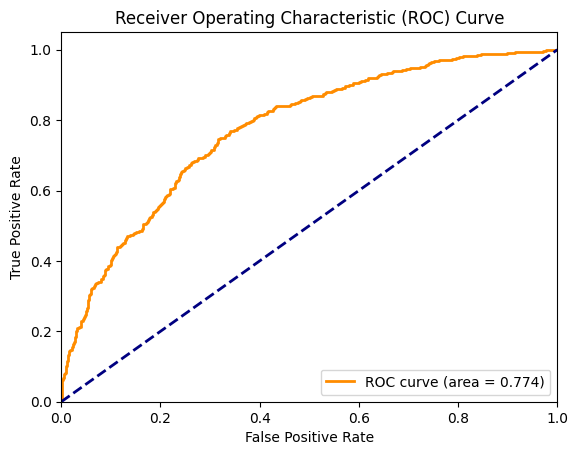

In [29]:
# Predict probabilities for the test set
y_probs = baseline_CNN.predict(X_test).reshape(X_test.shape[0], 1)  # Keep probabilities for the positive outcome only

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.reshape(X_test.shape[0], 1), y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# SHAP

In [156]:
import shap

background = X_train[:1000]
x_to_explain = X_test[:100]

explainer = shap.DeepExplainer(baseline_CNN, background)

shap_values = explainer.shap_values(x_to_explain)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [160]:
shap_values.shape
x_to_explain.shape

(100, 38, 1)

In [ ]:
shap_values = shap_values.reshape(100,38)

shap.summary_plot(shap_values, x_to_explain, plot_type="bar", max_display=25, feature_names=feature_names)

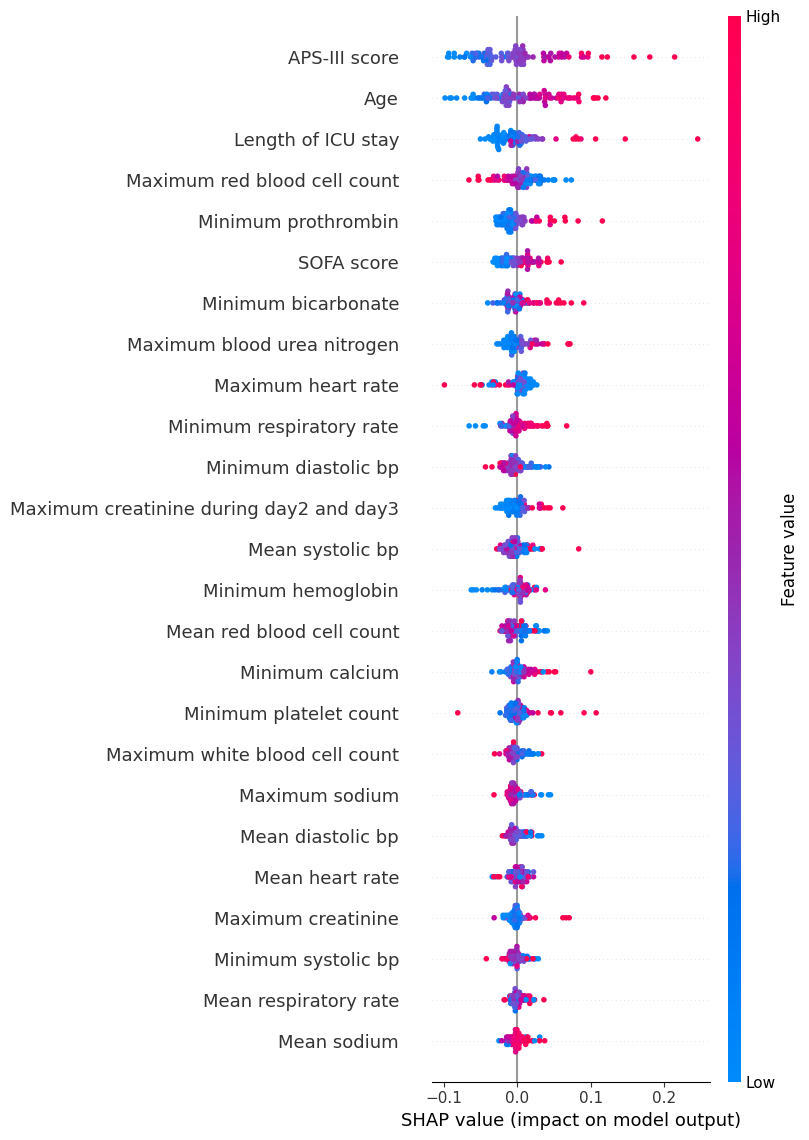

In [163]:
x_to_explain = x_to_explain.reshape(100,38)
shap.summary_plot(
    shap_values[:100, :], x_to_explain[:100, :], plot_type="dot", max_display=25, feature_names=feature_names
)

In [272]:
background = X_train[:1000]
x_to_explain = X_test[:100]

explainer = shap.DeepExplainer(baseline_CNN, background)

shap_values = explainer.shap_values(x_to_explain)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [264]:
shap_values[0].shape
# x_to_explain.shape

(38, 1, 1)

In [273]:
shap_values[1].shape
base_value = baseline_CNN.predict(background)
base_value = np.mean(base_value)

32/32 [==============================] - 0s 2ms/step


In [274]:
shap_values.shape
x_to_explain = x_to_explain.reshape(100,38,1,1)

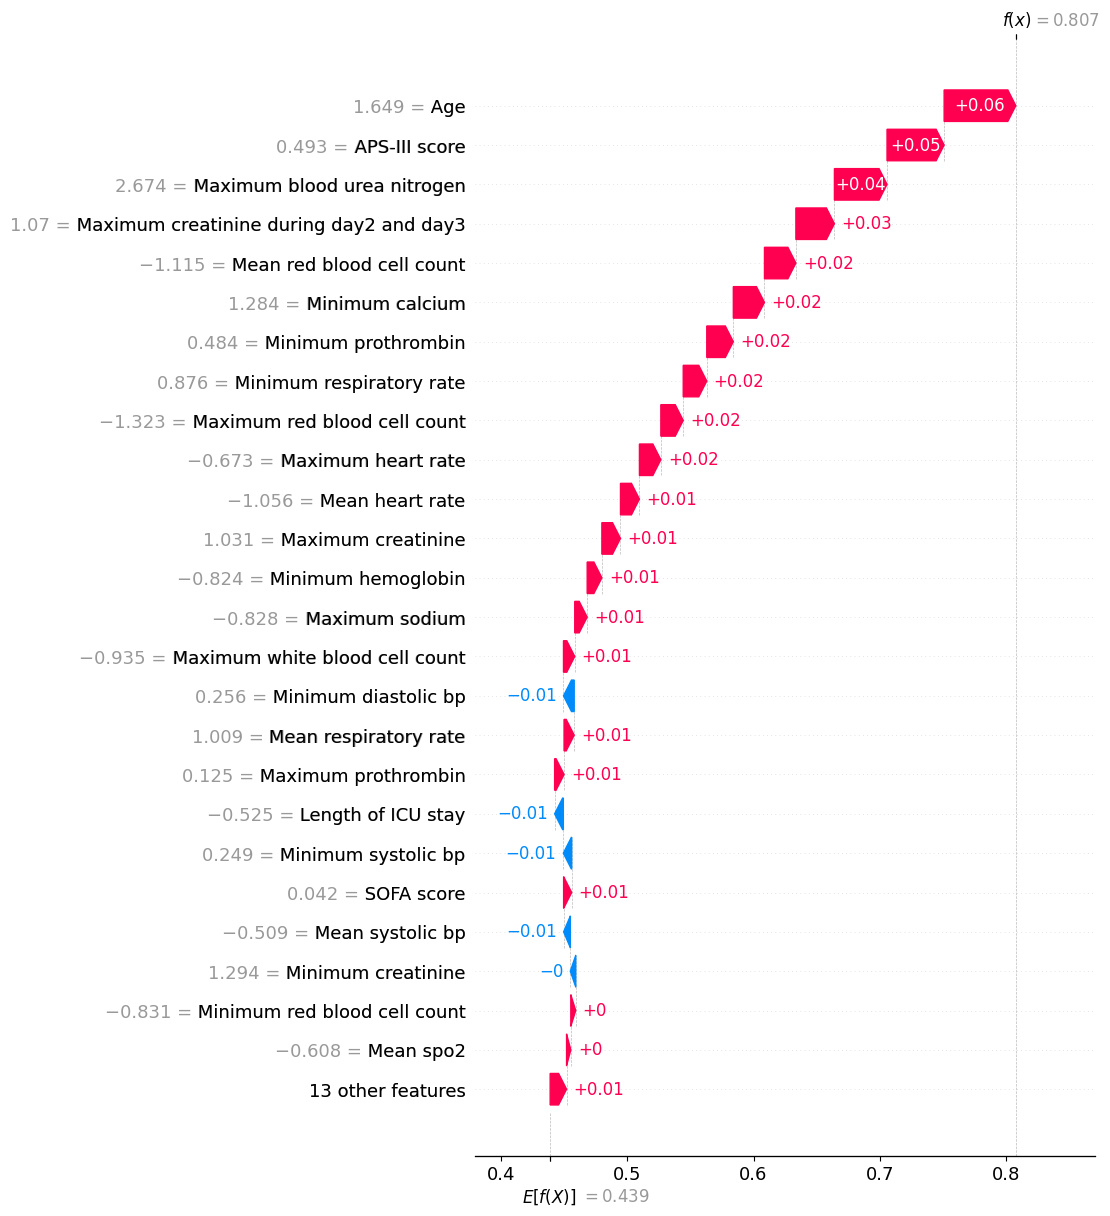

In [326]:
explanation = shap.Explanation(values=shap_values[90].reshape(38,), base_values=base_value, data=x_to_explain[90].reshape(38), feature_names=feature_names)
shap.plots.waterfall(explanation, max_display=26)

In [300]:
explanation = shap.Explanation(values=shap_values[20].reshape(38,), base_values=base_value, data=x_to_explain[20].reshape(38), feature_names=feature_names)

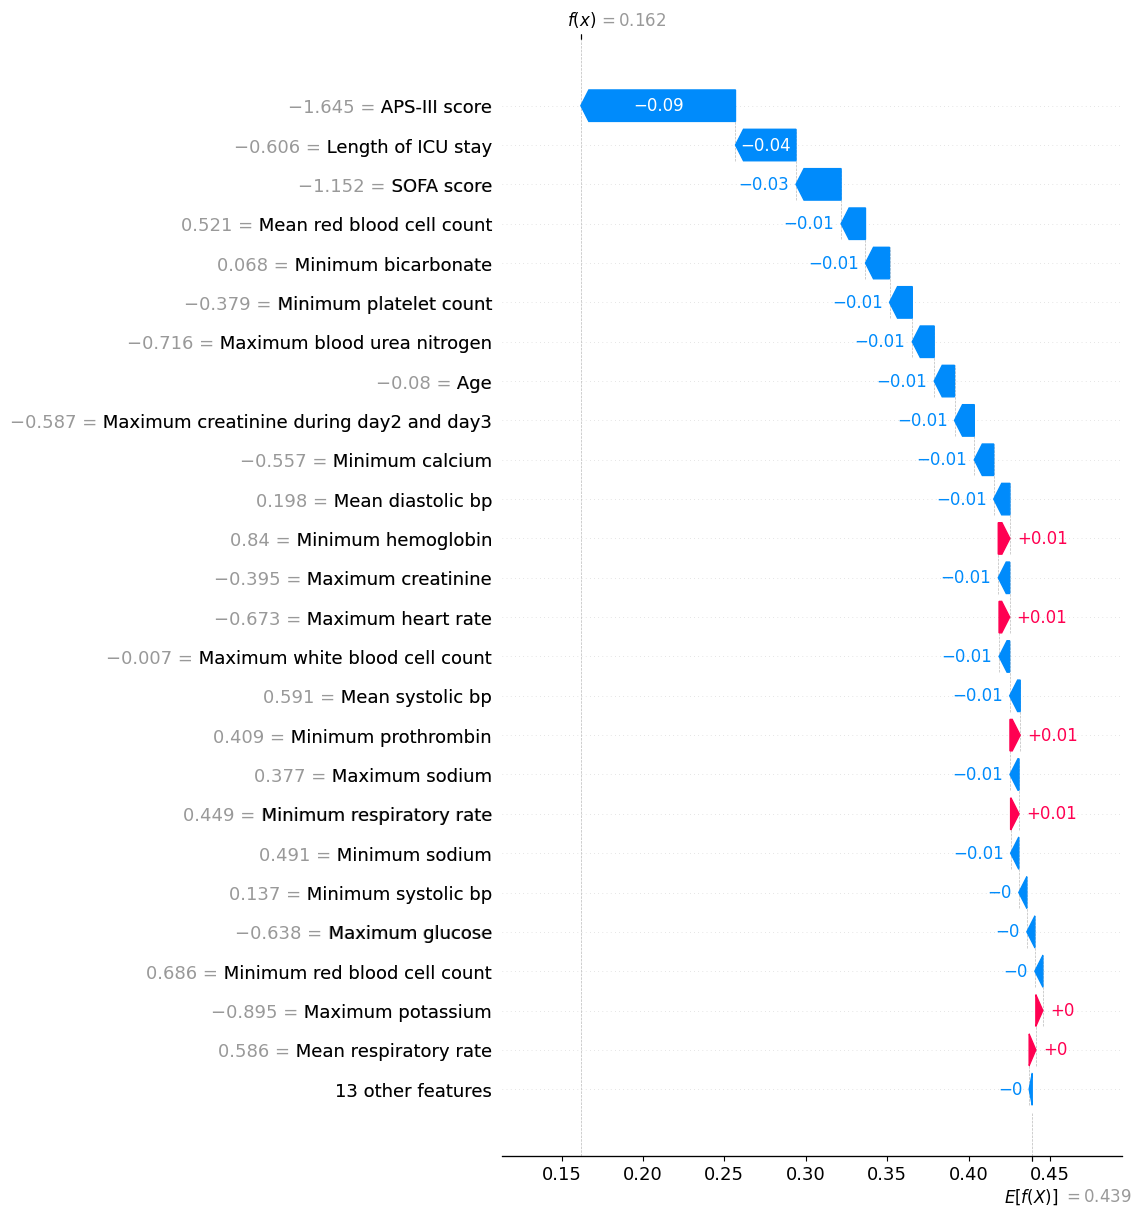

In [301]:
shap.plots.waterfall(explanation, max_display=26)

# Backward selection

In [55]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]

In [56]:
selected_features_CNN = print_feature_importances_shap_values(shap_values, feature_names)

In [76]:
selected_features_CNN

['APS-III score',
 'Age',
 'Length of ICU stay',
 'Maximum red blood cell count',
 'Minimum prothrombin',
 'SOFA score',
 'Minimum bicarbonate',
 'Maximum blood urea nitrogen',
 'Maximum heart rate',
 'Minimum respiratory rate',
 'Minimum diastolic bp',
 'Maximum creatinine during day2 and day3',
 'Mean systolic bp',
 'Minimum hemoglobin',
 'Mean red blood cell count',
 'Minimum calcium',
 'Minimum platelet count',
 'Maximum white blood cell count',
 'Maximum sodium',
 'Mean diastolic bp',
 'Mean heart rate',
 'Maximum creatinine',
 'Minimum systolic bp',
 'Mean respiratory rate',
 'Mean sodium']

In [63]:
y = dataset_copy['mortality']
X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
X = X.drop(columns=['stay_id'])
variables_cont = X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(X['gender'], drop_first=True)
variable_race = pd.get_dummies(X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)

In [64]:
X = X[selected_features_CNN].to_numpy()
y = y.to_numpy()

In [65]:
X.shape

(30096, 25)

In [67]:
X = X.reshape(30096, 25,1)
y = y.reshape(30096,1)

In [68]:
X.shape

(30096, 25, 1)

In [70]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
optimizer = Adam(learning_rate=0.0001)

# model selection by monitoring validation loss
checkpoint_path = "/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN_backward"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(25, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(filters=24, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['binary_accuracy', AUC(name='auc'), Precision(name='ppv'), Recall(name='sensitivity'), Specificity(), NPV()])

In [72]:
model.fit(X_train, y_train, epochs=30, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpoint])
# model.fit(X_train, Y_train, epochs=50, verbose=1, callbacks=[checkpoint_1])

Epoch 1/30
842/847 [============================>.] - ETA: 0s - loss: 0.5806 - binary_accuracy: 0.6975 - auc: 0.7608 - ppv: 0.6692 - sensitivity: 0.6540 - specificity: 0.7334 - npv: 0.7199
Epoch 1: val_loss improved from 0.57157 to 0.57121, saving model to /content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN_backward
847/847 [==============================] - 15s 18ms/step - loss: 0.5807 - binary_accuracy: 0.6973 - auc: 0.7606 - ppv: 0.6687 - sensitivity: 0.6541 - specificity: 0.7329 - npv: 0.7199 - val_loss: 0.5712 - val_binary_accuracy: 0.6837 - val_auc: 0.7680 - val_ppv: 0.6555 - val_sensitivity: 0.6536 - val_specificity: 0.7092 - val_npv: 0.7075
Epoch 2/30
839/847 [============================>.] - ETA: 0s - loss: 0.5799 - binary_accuracy: 0.6986 - auc: 0.7607 - ppv: 0.6713 - sensitivity: 0.6513 - specificity: 0.7376 - npv: 0.7200
Epoch 2: val_loss did not improve from 0.57121
847/847 [==============================] - 6s 7ms/step - loss: 0.5796 - binary_accuracy: 0.699

In [77]:
baseline_CNN_backward = tf.keras.models.load_model(checkpoint_path, custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_CNN_backward.evaluate(X_test, y_test, verbose=1)

48/48 [==============================] - 4s 20ms/step - loss: 0.5739 - binary_accuracy: 0.7030 - auc: 0.7699 - ppv: 0.6894 - sensitivity: 0.6425 - specificity: 0.7543 - npv: 0.7131


[0.5738965272903442,
 0.7029900550842285,
 0.7699075937271118,
 0.6894409656524658,
 0.6425470113754272,
 0.7542997598648071,
 0.7131242752075195]

In [83]:
np.save('/content/drive/MyDrive/Project_1_with_ye/Code/model/X_test_CNNback.npy', X_test)
np.save('/content/drive/MyDrive/Project_1_with_ye/Code/model/y_test_CNNback.npy', y_test)

48/48 [==============================] - 0s 4ms/step


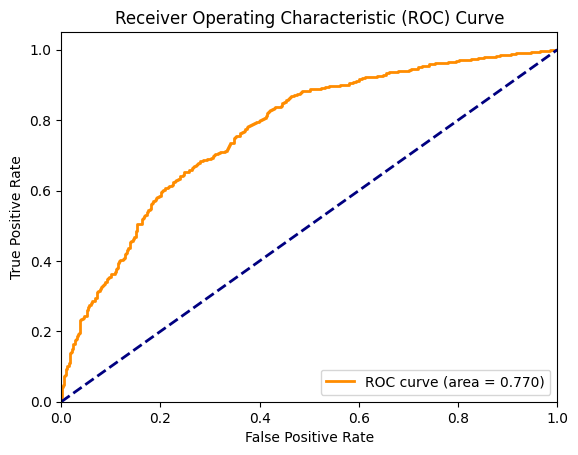

In [74]:
# Predict probabilities for the test set
y_probs = baseline_CNN_backward.predict(X_test).reshape(X_test.shape[0], 1)  # Keep probabilities for the positive outcome only

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.reshape(X_test.shape[0], 1), y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()